# Способы отрисовки поверхностей

## Расчеты SES поверхностей

Вот тут обозрены всякие методы (https://doi.org/10.1101/294025)
Какие методы можно выделить: 

Аналитические (Connoly PQMS https://doi.org/10.1016/0263-7855(93)87010-3, MSMS https://doi.org/10.1002/(SICI)1097-0282(199603)38:3<305::AID-BIP4>3.0.CO;2-Y). Плюсы: правильная поверхность, обычно в комплекте с триангуляцией, реализовано в пимоле. Минусы: долго, сложно, написано на эльфийском 200 лет назад. 

Решеточные (LSMS https://doi.org/10.1016/j.jmgm.2006.02.012, EDTSurf https://doi.org/10.1371/journal.pone.0008140). Плюсы: скорость (нет), треугольники. Минусы: нет нормалей, затратно (клятые воксели), написано на эльфийском.

dmasif (https://doi.org/10.1101/2020.12.28.424589) - градиентный спуск по функции smooth distance, фильтрация, сабсемплинг. Плюсы: быстро. Минусы: нестабильно, невоспроизводимо, лысые вогнутые места (хотя по факту должно быть наоборот), непроходимо для градиента. 

### Setup

In [1]:
# Dependencies
'''
! wget https://zhanggroup.org/EDTSurf/EDTSurf
! chmod u+x EDTSurf
! pip install -r requirements.txt

'''

'\n! wget https://zhanggroup.org/EDTSurf/EDTSurf\n! chmod u+x EDTSurf\n! pip install -r requirements.txt\n\n'

In [2]:
import sys,importlib
import torch
import os
import time
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline 

### Метрики сходства для облаков точек

In [3]:
try:
    importlib.reload(sys.modules['dmasif_surface'])
    importlib.reload(sys.modules['compute_SES'])
    importlib.reload(sys.modules['losses'])

except KeyError:
    pass

from dmasif_surface import get_smooth_surface # тут функция из dmasif
from compute_SES import computeMSMS, computeEDTSurf # тут классические функции
from losses import chamfer_distance, hausdorff_distance, distribution # тут лоссы

pdb_dir='protein_data/'


Возьмем случайную структуру и рассчитаем для нее поверхность разными способами

In [90]:
pdb_file=pdb_dir+os.listdir(pdb_dir)[0] 

print(pdb_file)

msms_vert, msms_face, msms_norm=computeMSMS(pdb_file)
edt_vert, edt_face=computeEDTSurf(pdb_file)
dmasif_vert, dmasif_norm = get_smooth_surface(pdb_file)


protein_data/4WZJ_XXX.pdb


Нарисуем результат

/home/domain/data/prog/miniconda3/envs/dmasif_upd/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


MSMS point number: 31228
dmasif point number: 8164
EDTSurf point number: 76374


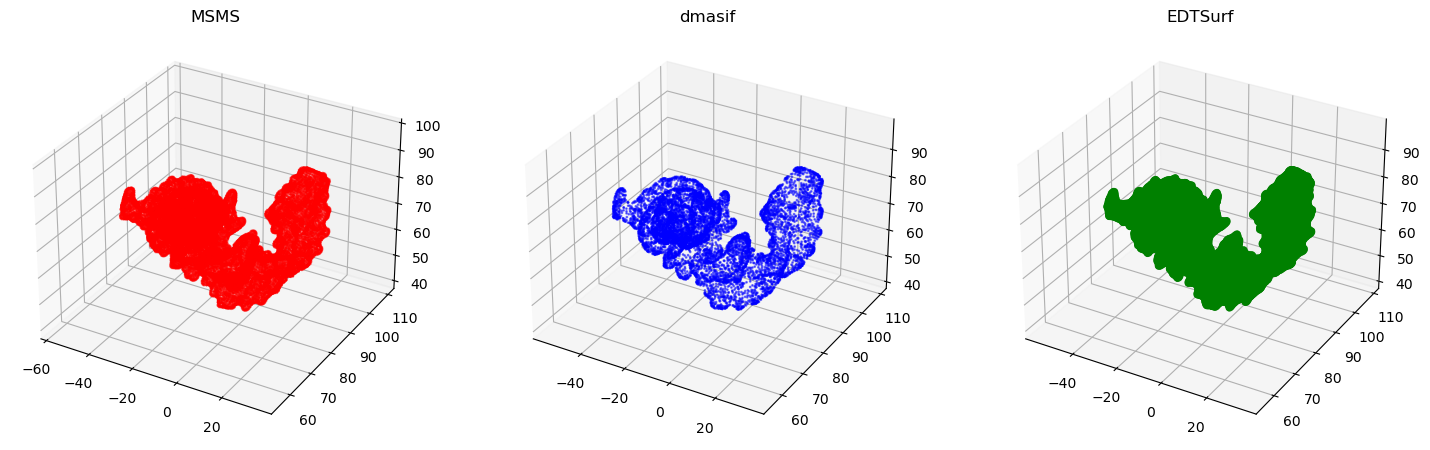

In [91]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*edt_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('EDTSurf')

fig.show()

print('MSMS point number:', msms_vert.shape[0])
print('dmasif point number:', dmasif_vert.shape[0])
print('EDTSurf point number:', edt_vert.shape[0])

Рассчитаем лоссы, сравним способ dmasif с MSMS (будем считать МSMS золотым стандартом)

In [92]:
d_ch_loss, d_norm_loss=chamfer_distance( dmasif_vert, torch.Tensor(msms_vert), dmasif_norm, torch.Tensor(msms_norm), single_directional=True)
d_haus_dist=hausdorff_distance(dmasif_vert, torch.Tensor(msms_vert))
print('Chamfer distance:',d_ch_loss.item())
print('Normal distance:',d_norm_loss.item())
print('Hausdorff distance:',d_haus_dist.item())

Chamfer distance: 0.3386051654815674
Normal distance: 0.08630812168121338
Hausdorff distance: 3.516693115234375


In [93]:
msms_dist=distribution(torch.Tensor(msms_vert), reduction='max')
dmasif_dist=distribution(dmasif_vert, reduction='max')
print('MSMS distribution:',msms_dist.item())
print('dMaSIF distribution:',dmasif_dist.item())

[KeOps] Generating code for formula Sum_Reduction(Step(Var(2,1,2)-Sum((Var(0,3,0)-Var(1,3,1))**2)),0) ... OK
MSMS distribution: 19.218650817871094
dMaSIF distribution: 9.487260818481445


### Простой метод

Сделаем самую простую детскую модель, которая будет просто рисовать рандомные точки по SAS поверхности, удалять внутренние точки, перемещать точки на радиус пробы и усреднять грид кластерингом для получения условной SES поверхности. 

In [94]:
try:
    importlib.reload(sys.modules['simple_surface'])
except KeyError:
    pass
from simple_surface import get_simple_surface

In [95]:
my_vert, my_norm = get_simple_surface(pdb_file)


2186 3 300


Проблема: для получения приемлевого количества точек нужно генерировать по 300 точек на атом, что может создать ограничения по памяти. При этом большая часть этих точек в итоге никак не сыграет, а будет отфильтрована. Была сделана попытка генерировать и отфильтровывать точки символьными функциями, но keops не работает с таким количеством измерений. 

MSMS point number: 31228
dMaSIF point number: 8164
Mine point number: 8653


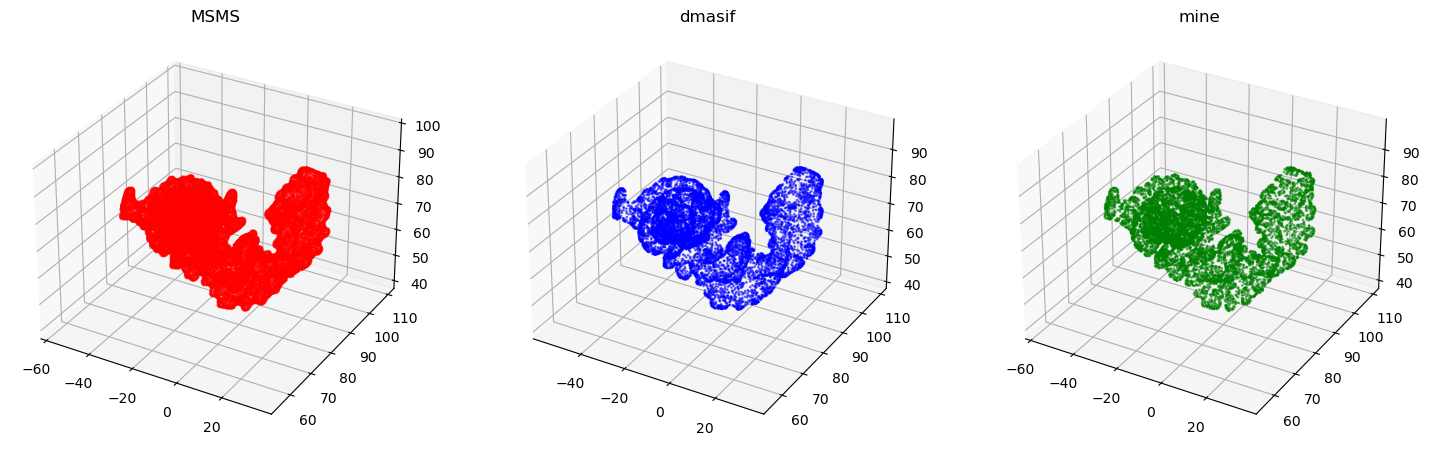

In [96]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*my_vert.T, s=1, color='green',alpha=0.5)
ax.set_title('mine')

print('MSMS point number:', msms_vert.shape[0])
print('dMaSIF point number:', dmasif_vert.shape[0])
print('Mine point number:', my_vert.shape[0])


In [97]:
m_ch_loss, m_norm_loss=chamfer_distance( my_vert, torch.Tensor(msms_vert), my_norm, torch.Tensor(msms_norm), single_directional=True)
m_haus_dist=hausdorff_distance(my_vert, torch.Tensor(msms_vert))
print('Chamfer distance:',m_ch_loss.item())
print('Normal distance:',m_norm_loss.item())
print('Hausdorff distance:',m_haus_dist.item())

my_dist=distribution(my_vert, reduction='max')
print('Distribution:',my_dist.item())

Chamfer distance: 0.26887452602386475
Normal distance: 0.02708578296005726
Hausdorff distance: 2.098378896713257
Distribution: 6.810123443603516


In [98]:
loss_col=chamfer_distance( my_vert, torch.Tensor(msms_vert),reduction=None)

fig=px.scatter_3d(x=my_vert[:,0],y=my_vert[:,1],z=my_vert[:,2], color=loss_col[0][0][:,0].log())
fig.update_traces(marker={'size': 2})
fig.update_layout(
    autosize=False, 
    width=1200, 
    height=800,
    scene = dict(
        xaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        zaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
    )
)

In [99]:
pd.DataFrame(index=['dmasif','mine'], columns=['chamfer','normal','hausdorff','distribution'],
             data=[[d_ch_loss.item(),d_norm_loss.item(), d_haus_dist.item(), dmasif_dist.item()],
                   [m_ch_loss.item(),m_norm_loss.item(), m_haus_dist.item(), my_dist.item()]])

,chamfer,normal,hausdorff,distribution
dmasif,0.338605,0.086308,3.516693,9.487261
mine,0.268875,0.027086,2.098379,6.810123


Результаты детского метода сравнимы с методом dmasif

## Нейронки

Для расчета точек поверхности нейронок нет, значит, можно написать самостоятельно

### Датасет

Сделаем неизбыточную выборку структур макромолекул. Я брала так: искала в pdb "CASP target", фильтровала asymmetric units и кластеризовала по 30% сходству, получилось 2337 белков, не совпадающих с белками из предыдущих выборок для обучения masif. Также нашла в недрах интернета выборку из 2863 неизбыточных РНК (https://doi.org/10.1093/nargab/lqad040) и тоже досыпала в свой датасет. Все это могущество протонировала.

In [ ]:
# Download and protonate pdbs
'''
! mkdir protein_data/
! python3 download_pdb.py -pdb_list prot_nrd.txt
! python3 download_pdb.py -pdb_list rna_nrd_2.txt

'''

In [17]:
try:
    importlib.reload(sys.modules['data'])
except KeyError:
    pass
from data import AtomSurfaceDataset, CollateDict

In [9]:
dataset=AtomSurfaceDataset(storage='structure_data.pkl') 
dataset[0].keys()

  0%|          | 15/5199 [00:19<4:12:59,  2.93s/it]

Failed to load 5DAT_5.pdb


  1%|          | 45/5199 [00:41<3:43:28,  2.60s/it]

Failed to load 7OHQ_1.pdb


  2%|▏         | 89/5199 [01:18<5:37:09,  3.96s/it]

Failed to load 6ZSC_XA.pdb


  2%|▏         | 111/5199 [01:27<49:50,  1.70it/s] 

Failed to load 3DG4_B.pdb


  2%|▏         | 116/5199 [01:40<4:24:41,  3.12s/it]

Failed to load 4V8B_BA.pdb


  3%|▎         | 176/5199 [02:20<4:10:04,  2.99s/it]

Failed to load 7LS2_A2.pdb


  4%|▍         | 199/5199 [02:42<3:55:57,  2.83s/it]

Failed to load 7JIL_1.pdb


  4%|▍         | 225/5199 [03:02<3:36:11,  2.61s/it]

Failed to load 6BZ6_RA.pdb


  6%|▌         | 316/5199 [04:41<1:14:48,  1.09it/s] 

Failed to load 3OQ5_D.pdb


  6%|▋         | 331/5199 [04:56<4:00:17,  2.96s/it]

Failed to load 4V4N_A1.pdb


  7%|▋         | 339/5199 [05:01<1:04:13,  1.26it/s]

Failed to load 4ADX_0.pdb


  8%|▊         | 427/5199 [06:01<3:46:16,  2.84s/it]

Failed to load 7OJ0_A.pdb


 11%|█         | 553/5199 [07:57<1:13:55,  1.05it/s]

Failed to load 6ZJ3_LG.pdb


 13%|█▎        | 663/5199 [09:13<2:54:57,  2.31s/it]

Failed to load 6ZM6_AA.pdb


 13%|█▎        | 690/5199 [09:37<41:35,  1.81it/s]  

Failed to load 6WW6_F.pdb


 14%|█▍        | 719/5199 [10:10<3:52:39,  3.12s/it]

Failed to load 6ZSD_r3.pdb


 14%|█▍        | 732/5199 [10:28<4:22:35,  3.53s/it]

Failed to load 6Z1P_Bb.pdb


 15%|█▍        | 760/5199 [10:59<31:05,  2.38it/s]  

Failed to load 6ZSD_r4.pdb


 15%|█▍        | 776/5199 [11:07<34:28,  2.14it/s]  

Failed to load 3DG5_B.pdb


 16%|█▌        | 819/5199 [11:46<3:36:09,  2.96s/it]

Failed to load 5O61_A.pdb


 16%|█▋        | 852/5199 [12:54<6:53:12,  5.70s/it] 

Failed to load 4U56_5.pdb


 17%|█▋        | 859/5199 [13:11<5:07:32,  4.25s/it]

Failed to load 6ZCE_A.pdb


 17%|█▋        | 869/5199 [13:26<2:48:34,  2.34s/it]

Failed to load 7AOI_AA.pdb


 18%|█▊        | 918/5199 [14:02<1:14:43,  1.05s/it]

Failed to load 8RC4_n.pdb


 18%|█▊        | 930/5199 [14:14<2:54:06,  2.45s/it]

Failed to load 5X8P_A.pdb


 20%|█▉        | 1022/5199 [15:23<4:10:09,  3.59s/it]

Failed to load 7ACJ_2.pdb


 20%|██        | 1055/5199 [15:51<4:05:24,  3.55s/it]

Failed to load 6IP8_1A.pdb


 22%|██▏       | 1148/5199 [16:45<3:10:54,  2.83s/it]

Failed to load 6SPD_A.pdb


 23%|██▎       | 1171/5199 [17:15<3:16:51,  2.93s/it]

Failed to load 2KWG_A.pdb


 23%|██▎       | 1192/5199 [17:35<2:15:30,  2.03s/it]

Failed to load 5T5H_A.pdb


 26%|██▌       | 1347/5199 [20:47<3:28:32,  3.25s/it]

Failed to load 6SWA_q.pdb


 26%|██▌       | 1356/5199 [21:01<3:20:59,  3.14s/it]

Failed to load 7BHP_L5.pdb


 27%|██▋       | 1384/5199 [21:26<2:09:55,  2.04s/it]

Failed to load 6UZ7_5.pdb


 27%|██▋       | 1399/5199 [21:40<2:28:00,  2.34s/it]

Failed to load 5V8I_2A.pdb


 27%|██▋       | 1409/5199 [21:53<2:39:50,  2.53s/it]

Failed to load 5XY3_1.pdb


 28%|██▊       | 1433/5199 [22:22<2:38:06,  2.52s/it]

Failed to load 6XYW_1.pdb


 29%|██▉       | 1527/5199 [23:49<2:51:48,  2.81s/it]

Failed to load 4V8P_A1.pdb


 30%|███       | 1579/5199 [25:02<46:05,  1.31it/s]   

Failed to load 4V48_A0.pdb


 31%|███       | 1619/5199 [25:58<2:03:14,  2.07s/it]

Failed to load 4V9Q_CA.pdb


 32%|███▏      | 1638/5199 [26:25<26:04,  2.28it/s]  

Failed to load 1JGQ_A.pdb


 32%|███▏      | 1646/5199 [26:41<3:51:18,  3.91s/it]

Failed to load 6ZM6_A.pdb


 32%|███▏      | 1671/5199 [27:05<2:38:10,  2.69s/it]

Failed to load 5MYJ_BA.pdb


 33%|███▎      | 1730/5199 [27:45<3:07:42,  3.25s/it]

Failed to load 5XXB_1.pdb


 37%|███▋      | 1932/5199 [31:12<2:16:47,  2.51s/it]

Failed to load 7N1P_16.pdb


 37%|███▋      | 1945/5199 [31:28<3:10:05,  3.50s/it]

Failed to load 6ZTO_AA.pdb


 38%|███▊      | 1977/5199 [32:00<36:22,  1.48it/s]  

Failed to load 4V47_A0.pdb


 38%|███▊      | 1984/5199 [32:12<2:30:44,  2.81s/it]

Failed to load 7ST2_1.pdb


 39%|███▊      | 2003/5199 [32:27<59:25,  1.12s/it]  

Failed to load 6Q95_4.pdb


 39%|███▉      | 2034/5199 [32:50<26:51,  1.96it/s]  

Failed to load 2FTC_R.pdb


 39%|███▉      | 2048/5199 [32:59<29:11,  1.80it/s]

Failed to load 2RDO_B.pdb


 40%|████      | 2096/5199 [33:32<20:27,  2.53it/s]  

Failed to load 4V42_BA.pdb


 40%|████      | 2097/5199 [33:32<18:33,  2.79it/s]

Failed to load 4R8I_B.pdb


 41%|████      | 2135/5199 [34:11<22:37,  2.26it/s]  

Failed to load 4V5Z_B0.pdb


 43%|████▎     | 2213/5199 [35:15<3:28:45,  4.19s/it]

Failed to load 7LS1_m2.pdb


 43%|████▎     | 2218/5199 [35:38<4:49:27,  5.83s/it]

Failed to load 5MRF_A.pdb


 43%|████▎     | 2246/5199 [35:55<23:07,  2.13it/s]  

Failed to load 1JGP_A.pdb


 43%|████▎     | 2254/5199 [36:12<3:00:01,  3.67s/it]

Failed to load 6VU3_D.pdb


 44%|████▍     | 2307/5199 [36:48<1:36:00,  1.99s/it]

Failed to load 6SGB_CA.pdb


 45%|████▌     | 2342/5199 [37:45<2:45:13,  3.47s/it]

Failed to load 4V7E_Aa.pdb


 45%|████▌     | 2345/5199 [37:58<3:57:02,  4.98s/it]

Failed to load 7O7Y_A2.pdb


 46%|████▌     | 2403/5199 [38:57<1:00:19,  1.29s/it]

Failed to load 5AJ4_BB.pdb


 49%|████▊     | 2527/5199 [41:14<2:18:57,  3.12s/it]

Failed to load 6HRM_1.pdb


 49%|████▉     | 2560/5199 [41:41<2:25:32,  3.31s/it]

Failed to load 6AWB_A.pdb


 49%|████▉     | 2562/5199 [41:41<1:16:46,  1.75s/it]

Failed to load 1JGO_A.pdb


 50%|████▉     | 2593/5199 [42:14<1:30:42,  2.09s/it]

Failed to load 6SKG_BA.pdb


 50%|████▉     | 2596/5199 [42:17<51:06,  1.18s/it]  

Failed to load 2IY3_B.pdb


 51%|█████▏    | 2677/5199 [44:01<3:36:30,  5.15s/it]

Failed to load 6Z1P_Ab.pdb


 55%|█████▍    | 2836/5199 [46:37<20:01,  1.97it/s]  

Failed to load 3DG0_B.pdb


 55%|█████▍    | 2840/5199 [46:43<53:51,  1.37s/it]

Failed to load 6SGA_CA.pdb


 55%|█████▌    | 2880/5199 [47:15<1:39:33,  2.58s/it]

Failed to load 7NHM_A.pdb


 56%|█████▌    | 2892/5199 [47:41<2:01:40,  3.16s/it]

Failed to load 7OG4_r3.pdb


 56%|█████▌    | 2910/5199 [48:02<1:29:35,  2.35s/it]

Failed to load 7OLC_1.pdb


 56%|█████▋    | 2930/5199 [48:36<2:22:39,  3.77s/it]

Failed to load 7ASN_A.pdb


 57%|█████▋    | 2969/5199 [49:12<1:33:42,  2.52s/it]

Failed to load 6O8W_A.pdb


 57%|█████▋    | 2970/5199 [49:22<2:47:04,  4.50s/it]

Failed to load 6VYQ_D.pdb


 57%|█████▋    | 2978/5199 [49:48<2:41:05,  4.35s/it]

Failed to load 6OKK_A.pdb


 57%|█████▋    | 2984/5199 [49:58<1:27:17,  2.36s/it]

Failed to load 7BL4_A.pdb


 58%|█████▊    | 2997/5199 [50:13<1:45:02,  2.86s/it]

Failed to load 7R81_A1.pdb


 58%|█████▊    | 2998/5199 [50:22<2:46:25,  4.54s/it]

Failed to load 4V7H_B5.pdb


 60%|█████▉    | 3109/5199 [52:27<1:54:13,  3.28s/it]

Failed to load 4D67_2.pdb


 65%|██████▌   | 3390/5199 [56:56<1:32:23,  3.06s/it]

Failed to load 7O1A_BA.pdb


 67%|██████▋   | 3478/5199 [58:40<1:58:18,  4.12s/it]

Failed to load 6XYW_2.pdb


 68%|██████▊   | 3533/5199 [59:47<18:54,  1.47it/s]  

Failed to load 1ML5_a.pdb


 69%|██████▉   | 3599/5199 [1:01:02<1:22:56,  3.11s/it]

Failed to load 6LSR_2.pdb


 69%|██████▉   | 3608/5199 [1:01:17<1:05:30,  2.47s/it]

Failed to load 6Y6X_L5.pdb


 70%|██████▉   | 3624/5199 [1:01:36<1:19:14,  3.02s/it]

Failed to load 7KGB_A.pdb


 71%|███████   | 3682/5199 [1:02:52<1:24:34,  3.34s/it]

Failed to load 7ANE_1.pdb


 71%|███████   | 3690/5199 [1:02:59<22:46,  1.10it/s]  

Failed to load 5WSG_E.pdb


 71%|███████   | 3703/5199 [1:03:22<1:13:58,  2.97s/it]

Failed to load 4V6U_B1.pdb


 72%|███████▏  | 3721/5199 [1:03:55<1:09:57,  2.84s/it]

Failed to load 6TH6_BA.pdb


 72%|███████▏  | 3767/5199 [1:04:40<1:35:25,  4.00s/it]

Failed to load 6ZMI_L5.pdb


 73%|███████▎  | 3772/5199 [1:04:54<1:48:15,  4.55s/it]

Failed to load 6YDP_BA.pdb


 73%|███████▎  | 3820/5199 [1:05:37<1:11:49,  3.13s/it]

Failed to load 4V3P_L1.pdb


 75%|███████▌  | 3907/5199 [1:07:16<20:32,  1.05it/s]  

Failed to load 6Z1P_Ba.pdb


 76%|███████▌  | 3926/5199 [1:07:37<24:29,  1.15s/it]

Failed to load 6VRD_C.pdb


 76%|███████▋  | 3975/5199 [1:08:07<13:32,  1.51it/s]

Failed to load 5AJ4_AY.pdb


 77%|███████▋  | 4017/5199 [1:09:05<30:55,  1.57s/it]  

Failed to load 6WW6_E.pdb


 78%|███████▊  | 4035/5199 [1:09:31<22:33,  1.16s/it]  

Failed to load 4V19_B.pdb


 79%|███████▉  | 4119/5199 [1:10:54<15:26,  1.17it/s]  

Failed to load 4V42_AA.pdb


 79%|███████▉  | 4124/5199 [1:10:56<09:40,  1.85it/s]

Failed to load 3DG2_B.pdb


 80%|███████▉  | 4136/5199 [1:11:04<15:29,  1.14it/s]

Failed to load 8RC4_j.pdb


 81%|████████▏ | 4226/5199 [1:12:52<1:02:26,  3.85s/it]

Failed to load 4V6W_A5.pdb


 82%|████████▏ | 4238/5199 [1:13:01<12:16,  1.30it/s]  

Failed to load 4V48_BA.pdb


 82%|████████▏ | 4250/5199 [1:13:21<1:05:37,  4.15s/it]

Failed to load 7O7Y_B5.pdb


 85%|████████▍ | 4403/5199 [1:15:52<37:34,  2.83s/it]  

Failed to load 3JBO_AA.pdb


 85%|████████▌ | 4439/5199 [1:16:34<36:36,  2.89s/it]

Failed to load 4V4B_B3.pdb


 87%|████████▋ | 4530/5199 [1:17:30<06:24,  1.74it/s]

Failed to load 2KWG_B.pdb
Failed to load 6ZSG_r3.pdb


 88%|████████▊ | 4575/5199 [1:18:09<36:42,  3.53s/it]

Failed to load 5MRF_aa.pdb


 88%|████████▊ | 4580/5199 [1:18:25<25:59,  2.52s/it]  

Failed to load 5AJ3_Y.pdb


 89%|████████▉ | 4653/5199 [1:19:28<24:41,  2.71s/it]

Failed to load 1C2W_B.pdb


 90%|█████████ | 4681/5199 [1:20:11<30:00,  3.48s/it]

Failed to load 4UJC_A2.pdb


 92%|█████████▏| 4788/5199 [1:22:52<26:12,  3.83s/it]  

Failed to load 6YWE_aa.pdb


 93%|█████████▎| 4858/5199 [1:24:16<15:29,  2.72s/it]

Failed to load 6YWY_A.pdb


 94%|█████████▍| 4913/5199 [1:25:12<17:11,  3.61s/it]

Failed to load 6VYR_D.pdb


 95%|█████████▍| 4925/5199 [1:25:25<10:43,  2.35s/it]

Failed to load 6RM3_L50.pdb


 95%|█████████▍| 4931/5199 [1:25:30<04:15,  1.05it/s]

Failed to load 4V5Z_AA.pdb


 95%|█████████▌| 4944/5199 [1:25:36<02:17,  1.85it/s]

Failed to load 3IY9_A.pdb


 96%|█████████▌| 4993/5199 [1:26:20<08:53,  2.59s/it]

Failed to load 6SPB_A.pdb


 97%|█████████▋| 5039/5199 [1:27:05<08:23,  3.15s/it]

Failed to load 6XU8_A5.pdb


 98%|█████████▊| 5093/5199 [1:27:55<01:09,  1.52it/s]

Failed to load 4V47_BA.pdb


100%|█████████▉| 5188/5199 [1:29:32<00:46,  4.20s/it]

Failed to load 7LHD_A.pdb


100%|██████████| 5199/5199 [1:29:41<00:00,  1.04s/it]


dict_keys(['atom_xyz', 'atom_rad', 'target_xyz', 'target_normals'])

In [12]:
len(dataset)

5077

In [18]:
train_set, val_set, _ = torch.utils.data.random_split(dataset, [77,50,4950])

In [19]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [20]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, collate_fn=CollateDict(device=device))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, collate_fn=CollateDict(device=device))

### Модель

In [21]:
import torch 
import torch.nn as nn
from pykeops.torch import LazyTensor
from batching import diagonal_ranges

Я переписала модель, теперь она выглядит пологичнее. Что там происходит: ищутся ближайшие к точке атомы, находятся расстояния и направления до них. Расстояния конкатенируются с фичами атомов (радиусами) и преобразуются полносвязными слоями. Затем полученные фичи домножаются на направления и суммируются по ближайшим атомам. Полученные векторы опять делятся на расстояния и направления. Расстояния преобразуются линейными слоями, а направления конкатенируются с нормалями. Все это снова перемножается, и оттуда вычленяются векторы, на которые будут изменены координаты и нормали. Это делается несколько раз (вот тут не уверена, будет ли через такую модель хорошо проходить градиентный спуск?)

In [34]:

def knn_atoms(x, y, x_batch, y_batch, k):
    N, D = x.shape
    x_i = LazyTensor(x[:, None, :])
    y_j = LazyTensor(y[None, :, :])

    pairwise_distance_ij = ((x_i - y_j) ** 2).sum(-1)
    pairwise_distance_ij.ranges = diagonal_ranges(x_batch, y_batch)

    # N.B.: KeOps doesn't yet support backprop through Kmin reductions...
    # dists, idx = pairwise_distance_ij.Kmin_argKmin(K=k,axis=1)
    # So we have to re-compute the values ourselves:
    idx = pairwise_distance_ij.argKmin(K=k, axis=1)  # (N, K)
    x_ik = y[idx.view(-1)].view(N, k, D)
    dists = torch.sqrt(((x[:, None, :] - x_ik) ** 2).sum(-1))

    return idx, dists

class AtomShift(nn.Module):
    def __init__(self, in_dims, emb_dims, k=4):
        super(AtomShift, self).__init__()
        self.in_dims = in_dims
        self.emb_dims = emb_dims
        self.k = k

        self.transform_types = nn.Sequential(
            nn.Linear(self.in_dims+1,self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims, self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims, self.emb_dims),
            nn.LeakyReLU(negative_slope=0.2),
        )

        self.emb = nn.Sequential(
            nn.Linear(self.emb_dims, self.emb_dims+1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims+1, self.emb_dims*2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(self.emb_dims*2, (self.emb_dims+1)*2),
        )

    def forward(self, xyz, norm, atom_xyz, atomtypes, batch, atom_batch):

        idx, dists = knn_atoms(xyz, atom_xyz, batch, atom_batch, k=self.k)
        vecs=(xyz[:,None,:]-atom_xyz[idx.view(-1), :].view(-1, self.k, 3))/dists[:,:,None]

        if len(atomtypes.shape)<2:
            atomtypes=atomtypes[:,None]
        fx=torch.cat((atomtypes[idx.view(-1), :].view(-1, self.k, self.in_dims),
                      dists[:,:,None]), dim=-1) 
        fx=self.transform_types(fx) #(N, k, emb_dims)
        vecs=(fx[:,:,None,:]*vecs[:,:,:,None]).sum(1) #(N, 3, emb_dims)

        fx=(vecs**2).sum(1).sqrt() #(N, emb_dims)
        vecs=vecs/fx[:,None,:] #(N, 3, emb_dims)
        vecs=torch.cat((norm[:,:,None], vecs), dim=-1) 

        fx=self.emb(fx).view(-1,2,self.emb_dims+1)
        fx=(fx[:,None,:,:]*vecs[:,:,None,:]).sum(-1)

        dxyz = fx[:,:,0]
        dnorm = fx[:,:,1]

        return dxyz, dnorm

class ModelHuel(nn.Module):

    def __init__(self, distance=1.05, sup_sampling=20, n_shifts=4):
        super(ModelHuel, self).__init__()

        self.distance=distance
        self.sup_sampling=sup_sampling
        self.n_shifts=n_shifts
        self.shift=AtomShift(in_dims=1, emb_dims=4)

    def init_points(self, prot):

        atoms=prot['atom_xyz']
        batch_atoms = prot['atom_xyz_batch']

        T = self.distance
        N, D = atoms.shape
        B = self.sup_sampling 

        batch_z = batch_atoms[:, None].repeat(1, B).view(N * B)
        r =  T * torch.randn(N, B, D).type_as(atoms)
        z = (atoms[:, None, :] + r).view(-1, D) 
        norm = (r / (r**2).sum(1, keepdim=True).sqrt()).view(-1, D)
 
        prot['xyz']=z
        prot['normals']=norm
        prot['xyz_batch']=batch_z

    def forward(self, prot):
        if 'xyz' not in prot:
            self.init_points(prot)
        
        for _ in range(self.n_shifts):        
            dxyz, dnorm=self.shift(
                prot['xyz'],prot['normals'],
                prot['atom_xyz'],prot['atom_rad'],
                prot['xyz_batch'],prot['atom_xyz_batch'])
            prot['xyz']+=dxyz
            prot['normals']+=dnorm
        
        return prot

In [23]:
try:
    importlib.reload(sys.modules['losses'])
except KeyError:
    pass
from losses import SurfaceCriterion


Обучим модель

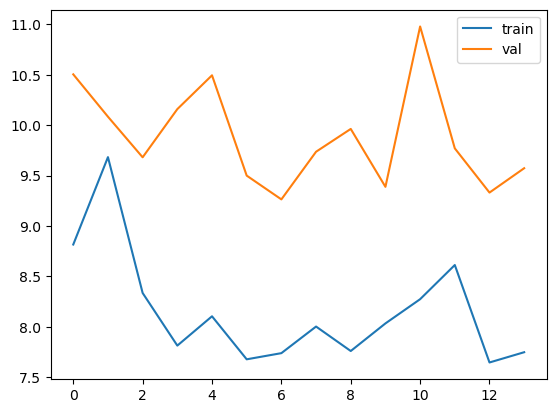

KeyboardInterrupt: 

In [35]:
model=ModelHuel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = SurfaceCriterion(hausdorff_weight=0.2,distribution_weight=0.1)
n_epochs=100

train_losses=[]
val_losses=[]

for epoch in range(n_epochs):  # number of epochs
    model.train()
    training_loss = 0
    for data in train_loader: 
        optimizer.zero_grad()

        out = model(data)
        loss = criterion(out)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
    #print(f'Training loss: {training_loss/len(train_loader)}')
    train_losses.append(training_loss/len(train_loader))
    model.eval()
    val_loss = 0
    for data in val_loader: 
        out = model(data)
        loss = criterion(out)
        
        val_loss += loss.item()
    #print(f'Validation loss: {val_loss/len(val_loader)}')
    val_losses.append(val_loss/len(val_loader))

    clear_output()
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.show()

In [153]:
torch.autograd.set_detect_anomaly(True)

Нихрена не обучается, надо бы оптимизировать гиперпараметры, повставлять всякие нормализации, уточнить лоссы.

MSMS point number: 28673
Mine point number: 40500


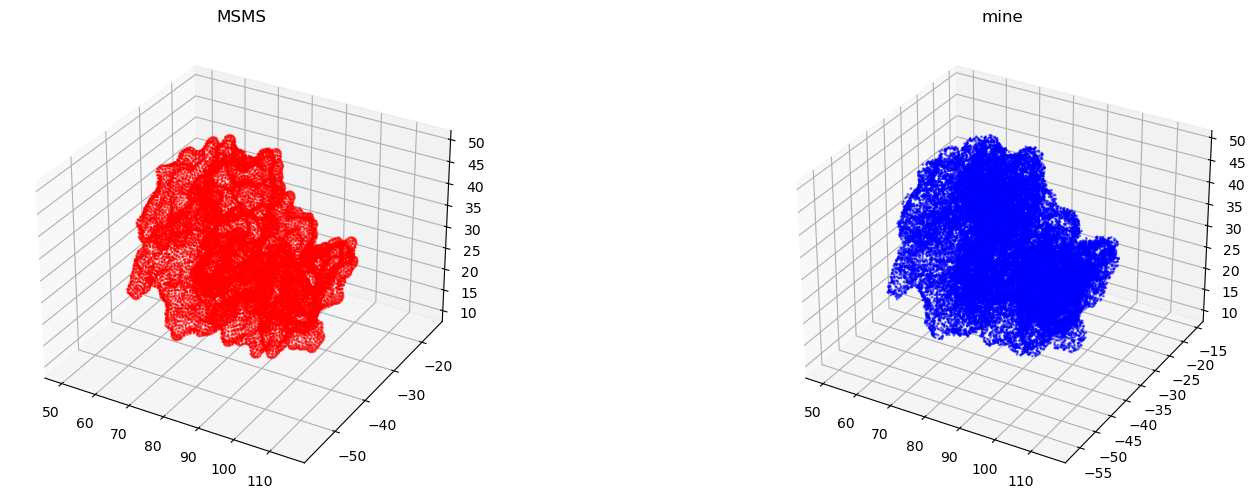

In [37]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(*out['target_xyz'].detach().cpu().numpy().T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*out['xyz'].detach().cpu().numpy().T, s=1, color='blue',alpha=0.5)
ax.set_title('mine')


print('MSMS point number:', out['target_xyz'].shape[0])
print('Mine point number:', out['xyz'].shape[0])


## Способы триангуляции

Это пока не нужно

In [ ]:
import numpy as np
import k3d
from compute_triangles import split_triangles, delaunay

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#cells=split_triangles(my_vert)
cells=delaunay(my_vert)

In [ ]:
plot = k3d.plot()
plot+=k3d.points(my_vert, point_size=0.2, shader='flat')
plot+=k3d.mesh(my_vert,cells, side='double', color=0x32ff31)

plot.display()

Output()